## Polynomial Chaos Expansion Example 7

Authors: Dimitris Loukrezis, Katiana Kontolati \
Date: January 20, 2021

In this example, PCE is used to generate a surrogate model for a given set of 2D data for a numerical model with multi-dimensional outputs.

Import necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from UQpy.Surrogates import *

The analytical function below describes the eigenvalues of the 2D Helmholtz equation on a square.

In [2]:
def analytical_eigenvalues_2d(Ne, lx, ly):
    """
    Computes the first Ne eigenvalues of a rectangular waveguide with 
    dimensions lx, ly

    Parameters
    ----------
    Ne : integer
         number of eigenvalues.
    lx : float
         length in x direction.
    ly : float
         length in y direction.

    Returns
    -------
    ev : numpy 1d array
         the Ne eigenvalues
    """
    ev = [(m*np.pi/lx)**2 + (n*np.pi/ly)**2 for m in range(1, Ne+1) 
                                            for n in range(1, Ne+1)]                                                 
    ev = np.array(ev)
    
    ### Uncertainty changes the sorting order of the eigenvalues. 
    ### The resulting value "jumps" cannot be captured by a PCE.   
    # sort eigenvalues and take the first Ne ones
    #idx = np.argsort(ev)[:Ne]    
    #ev  = ev[idx]
    
    return ev[:Ne]


Create a distribution object.

In [3]:
pdf_lx = Normal(loc=2, scale=0.02)   
pdf_ly = Normal(loc=1, scale=0.01)
margs = [pdf_lx, pdf_ly]
joint = JointInd(marginals=margs)

Define the number of input dimensions and choose the number of output dimensions (number of eigenvalues).

In [4]:
dim_in = 2
dim_out = 10 

Construct PCE models by varying the maximum degree of polynomials (and therefore the number of polynomial basis) and compute the validation error for all resulting models.

In [5]:
errors = []
basis = []
pce_models = []

for max_degree in range(1,6):
    print('Total degree: ', max_degree)
    
    # Polynomial basis
    polys = Polynomials(dist_object=joint, degree=max_degree)
    n_basis = math.factorial(max_degree+dim_in) / \
             (math.factorial(max_degree)*math.factorial(dim_in))
    basis.append(int(n_basis))
    print('Basis terms: ', int(n_basis))
    
    # Regression method
    #regression_method = PolyChaosLstsq(poly_object=polys)
    regression_method = PolyChaosLasso(poly_object=polys, learning_rate=0.01, iterations=50000, penalty=0)
    #regression_method = PolyChaosRidge(poly_object=polys, learning_rate=0.001, iterations=10000, penalty=0)

    pce = PCE(method=regression_method) 
    pce_models.append(pce)
    
    # Training data
    sampling_coeff = 4
    print('Sampling coefficient: ', sampling_coeff)
    
    np.random.seed(42)
    n_samples = math.ceil(sampling_coeff*n_basis)
    print('Training data: ', n_samples)
    xx = joint.rvs(n_samples)
    yy = np.array([analytical_eigenvalues_2d(dim_out, x[0], x[1]) for x in xx])

    # Design matrix / conditioning
    D = polys.evaluate(xx)
    cond_D = np.linalg.cond(D)
    print('Condition number: ', cond_D)
    
    # Fit model
    pce.fit(xx,yy)
    
    # Coefficients
    #print('PCE coefficients: ', pce.C)
    
    # Validation errors
    np.random.seed(999)
    n_samples = 1000
    x_val = joint.rvs(n_samples)
    y_val = np.array([analytical_eigenvalues_2d(dim_out, x[0], x[1]) for x in x_val])
    y_val_pce = pce.predict(x_val)

    error_val = ErrorEstimation(surr_object=pce).validation(x_val, y_val)
    errors.append(error_val)
    print('Validation error: ', error_val)
    print('')

Total degree:  1
Basis terms:  3
Sampling coefficient:  4
Training data:  12
Condition number:  2.0882052418227084
Validation error:  [0.0006748 0.0007259 0.0007376 0.0007419 0.0007438 0.0007449 0.0007456
 0.000746  0.0007463 0.0007465]

Total degree:  2
Basis terms:  6
Sampling coefficient:  4
Training data:  24
Condition number:  2.8416726057868082
Validation error:  [3.e-07 3.e-07 3.e-07 3.e-07 3.e-07 3.e-07 3.e-07 3.e-07 3.e-07 3.e-07]

Total degree:  3
Basis terms:  10
Sampling coefficient:  4
Training data:  40
Condition number:  7.181656103038829
Validation error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Total degree:  4
Basis terms:  15
Sampling coefficient:  4
Training data:  60
Condition number:  18.272397260927004
Validation error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Total degree:  5
Basis terms:  21
Sampling coefficient:  4
Training data:  84
Condition number:  74.16122503507886
Validation error:  [1.4575179 1.2049653 1.150906  1.1316233 1.1226427 1.1177505 1.1147961
 1.1128768 1.11

Plot errors.

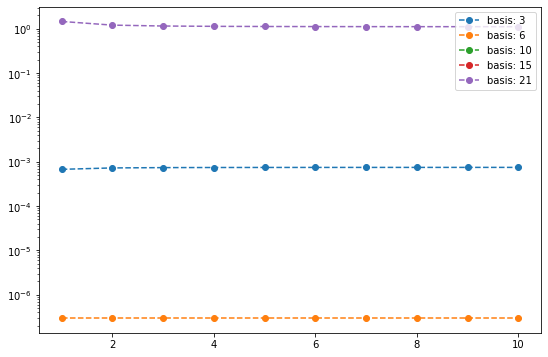

In [6]:
errors = np.array(errors)
plt.figure(1, figsize=(9,6))
for i in range(np.shape(errors)[0]):
    plt.semilogy(np.linspace(1, dim_out, dim_out), errors[i], '--o', label='basis: {}'.format(basis[i]))
plt.legend()
plt.show()

Moment estimation (directly estimated from the PCE model of max_degree = 2).

In [7]:
print('First moments estimation from PCE :', MomentEstimation(surr_object=pce_models[1]).get()[0])
print('')
print('Second moments estimation from PCE :', MomentEstimation(surr_object=pce_models[1]).get()[1])

First moments estimation from PCE : [ 12.3407  41.9584  91.3212 160.4291 249.2821 357.8803 486.2236 634.312
 802.1455 989.7242]

Second moments estimation from PCE : [4.150000e-02 6.267000e-01 3.162500e+00 9.989800e+00 2.438550e+01
 5.056320e+01 9.367240e+01 1.597993e+02 2.559660e+02 3.901312e+02]


Moment estimation via Monte Carlo integration.

In [8]:
n_mc = 100000
x_mc = joint.rvs(n_mc)
y_mc = np.array([analytical_eigenvalues_2d(dim_out, x[0], x[1]) for x in x_mc])
mu = np.mean(y_mc,axis=0)
moments = (np.round((1/n_mc)*np.sum(y_mc,axis=0),4), np.round((1/n_mc)*np.sum((y_mc-mu)**2,axis=0),4))
print('First moments from Monte Carlo integration: ', moments[0])
print('')
print('Second moments from Monte Carlo integration: ', moments[1])

First moments from Monte Carlo integration:  [ 12.3412  41.9607  91.3264 160.4385 249.2968 357.9015 486.2524 634.3497
 802.1932 989.7831]

Second moments from Monte Carlo integration:  [4.130000e-02 6.258000e-01 3.159200e+00 9.980500e+00 2.436420e+01
 5.052060e+01 9.359530e+01 1.596696e+02 2.557605e+02 3.898204e+02]
